In [20]:
### import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Charger les fichiers CSV
data = pd.read_csv("PBC_APL_all_features_noyau_1_2.csv")

# Supprimer les colonnes indésirables
cols_a_supprimer = ["Nom", "Numéro", "dataset", "Boîte encadrante", "Centre"]
data = data.drop(columns=cols_a_supprimer)
data = data[~data['Classe'].isin(['giant thrombocyte','lymphocyte, variant','plasma cells','promonocyte'])]
# 1. Création de nouvelles caractéristiques
#data['ratio_surface_perimetre'] = data['Aire noyau'] / data['Périmètre noyau']
#data['log_surface'] = np.log(data['Aire noyau'] + 1e-5)

# 2. Regroupement (Binning)
#intervalles = [0, 5000, 10000, 20000, np.inf]
#etiquettes = ['1', '2', '3', '4']  # 1 'petite', 2 'moyenne', 3 'grande', 4 'très grande'
#data['surface_regroupee'] = pd.cut(data['Aire noyau'], bins=intervalles, labels=etiquettes)

# 3. Interaction entre les caractéristiques
#data['interaction_surface_perimetre'] = data['Aire noyau'] * data['Périmètre noyau']

# Créer une copie explicite du DataFrame pour éviter les avertissements SettingWithCopyWarning
data_nettoyee = data.copy()

# Calculer les statistiques descriptives pour les colonnes numériques
#desc_stats = data_nettoyee.describe()

# Visualiser les boîtes à moustaches pour les caractéristiques numériques
#plt.figure(figsize=(15,10))

# On sélectionne les caractéristiques numériques pour la visualisation
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns
data_to_plot = data[numerical_features]


# Afficher les boîtes à moustaches
#sns.boxplot(data=data_to_plot)
#plt.xticks(rotation=90)  # Rotation des labels pour une meilleure lisibilité
#plt.title('Boxplot des caractéristiques numériques')
plt.show()

# Calcul de l'IQR pour chaque caractéristique numérique
Q1 = data_to_plot.quantile(0.25)
Q3 = data_to_plot.quantile(0.75)
IQR = Q3 - Q1

# Définition des seuils pour les valeurs aberrantes
borne_inf = Q1 - 1.5 * IQR
borne_sup = Q3 + 1.5 * IQR

# Identification des lignes avec des valeurs aberrantes
valeurs_aberrantes = (data_to_plot < borne_inf) | (data_to_plot > borne_sup)

# Calcul du nombre total de valeurs aberrantes pour chaque caractéristique
nombre_valeurs_aberrantes = valeurs_aberrantes.sum(axis=0)

# Suppression des lignes contenant des valeurs aberrantes
data_nettoyee = data[~(valeurs_aberrantes.any(axis=1))]

# Nombre de lignes avant et après la suppression des valeurs aberrantes
lignes_avant = data.shape[0]
lignes_apres = data_nettoyee.shape[0]
lignes_supprimees = lignes_avant - lignes_apres

print(lignes_avant, lignes_apres, lignes_supprimees, nombre_valeurs_aberrantes)

# Définition des nouvelles caractéristiques à partir des caractéristiques existantes
#data_nettoyee['ratio_aspect'] = data_nettoyee['Petit axe noyau'] / data_nettoyee['Grand axe noyau']
#data_nettoyee['surface_carree'] = data_nettoyee['Aire noyau'] ** 2
#data_nettoyee['perimetre_carre'] = data_nettoyee['Périmètre noyau'] ** 2
#data_nettoyee['solidite_carree'] = data_nettoyee['Solidité noyau'] ** 2
#data_nettoyee['produit_surface_perimetre'] = data_nettoyee['Aire noyau'] * data_nettoyee['Périmètre noyau']
#data_nettoyee['surface_regroupee_quantile'] = pd.qcut(data_nettoyee['Aire noyau'], q=4, labels=False)

# Affichage des nouvelles caractéristiques ajoutées
#data_nettoyee[['ratio_aspect', 'surface_carree', 'perimetre_carre', 'solidite_carree',
#               'produit_surface_perimetre', 'surface_regroupee_quantile']]

data_nettoyee.head()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Créer une copie profonde du DataFrame pour éviter le SettingWithCopyWarning
data_nettoyee_copy = data_nettoyee.copy()

# 1. Convertir les classes en valeurs numériques
label_encoder = LabelEncoder()
data_nettoyee['Classe'] = label_encoder.fit_transform(data_nettoyee['Classe'])

# 2. Séparer les caractéristiques et la variable cible
X = data_nettoyee.drop(['Classe', 'Chemin image'], axis=1)  # On élimine 'Chemin image' car c'est une caractéristique non numérique
y = data_nettoyee['Classe']

# 3. Normaliser les caractéristiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Afficher les formes des ensembles pour confirmation
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Nombre de features pour la couche d'entrée
input_shape = X_train.shape[1]
num_classes=13
# Construction du modèle
model = Sequential([Dense(64, input_shape=(input_shape,), activation='relu'),
                    Dense(32, activation='relu'),
                    Dense(num_classes, activation='softmax')
                   ])

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)

# Obtenir l'historique des précisions pour l'entraînement et la validation
precisions_entrainement = history.history['accuracy']
precisions_validation = history.history['val_accuracy']

# Calculer la précision moyenne sur tous les époques pour l'entraînement
precision_moyenne_entrainement = np.mean(precisions_entrainement)

# Trouver la meilleure précision pour l'entraînement et la validation
meilleure_precision_entrainement = max(precisions_entrainement)
meilleure_precision_validation = max(precisions_validation)

# Afficher la précision moyenne et les meilleures précisions
print(f'Précision moyenne sur l\'entraînement: {precision_moyenne_entrainement:.4f}')
print(f'Meilleure précision d\'entraînement: {meilleure_precision_entrainement:.4f}')
print(f'Meilleure précision de validation: {meilleure_precision_validation:.4f}')


26146 22838 3308 Aire noyau                      2045
Périmètre noyau                 1040
Largeur du rectangle minimal    1719
Hauteur du rectangle minimal    1579
Rayon noyau                     1104
Petit axe noyau                 1358
Grand axe noyau                 2494
Excentricité noyau                 0
Périmètre convexe noyau         2584
Solidité noyau                     4
dtype: int64


C:\Users\C. MATTEI\AppData\Local\Temp\ipykernel_10756\850003934.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nettoyee['Classe'] = label_encoder.fit_transform(data_nettoyee['Classe'])


Epoch 1/100
115/115 [==============================] - 4s 5ms/step - loss: 1.8012 - accuracy: 0.4296 - val_loss: 1.3182 - val_accuracy: 0.5698
Epoch 2/100
115/115 [==============================] - 0s 3ms/step - loss: 1.1760 - accuracy: 0.6066 - val_loss: 1.0725 - val_accuracy: 0.6207
Epoch 3/100
115/115 [==============================] - 0s 3ms/step - loss: 1.0308 - accuracy: 0.6465 - val_loss: 0.9834 - val_accuracy: 0.6576
Epoch 4/100
115/115 [==============================] - 0s 3ms/step - loss: 0.9703 - accuracy: 0.6643 - val_loss: 0.9322 - val_accuracy: 0.6713
Epoch 5/100
115/115 [==============================] - 0s 3ms/step - loss: 0.9298 - accuracy: 0.6773 - val_loss: 0.8950 - val_accuracy: 0.6834
Epoch 6/100
115/115 [==============================] - 0s 3ms/step - loss: 0.9005 - accuracy: 0.6860 - val_loss: 0.8724 - val_accuracy: 0.6927
Epoch 7/100
115/115 [==============================] - 0s 3ms/step - loss: 0.8784 - accuracy: 0.6967 - val_loss: 0.8504 - val_accuracy: 0.6998

In [21]:
# Affichage des noms de toutes les colonnes dans data_cleaned
column_names = data_nettoyee.columns.tolist()
column_names


['Aire noyau',
 'Périmètre noyau',
 'Largeur du rectangle minimal',
 'Hauteur du rectangle minimal',
 'Rayon noyau',
 'Petit axe noyau',
 'Grand axe noyau',
 'Excentricité noyau',
 'Périmètre convexe noyau',
 'Solidité noyau',
 'Chemin image',
 'Classe']

In [22]:
data_nettoyee['Classe'].value_counts()

Classe
7    4287
5    3270
2    3138
4    2869
8    2314
6    2064
1    1832
3    1830
0    1234
Name: count, dtype: int64

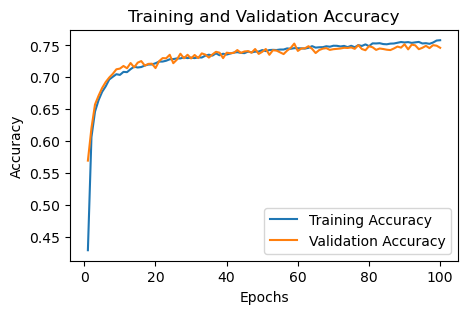

In [23]:
import matplotlib.pyplot as plt

# Supposons que vous ayez un objet history provenant de l'entraînement de votre modèle
# history = model.fit(...)

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Tracer les courbes d'accuracy et val_accuracy
epochs = range(1, len(accuracy) + 1)
plt.figure(figsize=(5, 3))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [24]:
# Création du LabelEncoder et encodage des classes
label_encoder = LabelEncoder()
data_nettoyee['Classe'] = label_encoder.fit_transform(data_nettoyee['Classe'])

# Pour obtenir les étiquettes de classe originales :
class_labels = label_encoder.inverse_transform(data_nettoyee['Classe'])

# Afficher les étiquettes de classe uniques
unique_class_labels = np.unique(class_labels)
print(unique_class_labels)


[0 1 2 3 4 5 6 7 8]


C:\Users\C. MATTEI\AppData\Local\Temp\ipykernel_10756\3919590164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nettoyee['Classe'] = label_encoder.fit_transform(data_nettoyee['Classe'])


In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Supposons que X_test est votre ensemble de données de test et y_test sont les étiquettes réelles correspondantes.
# Assurez-vous que votre modèle est déjà entraîné.

# Obtenir les prédictions
predictions = model.predict(X_test)

# Si votre problème est une classification binaire, vous pourriez vouloir arrondir les prédictions pour obtenir des classes discrètes
# predicted_classes = (predictions > 0.5).astype(int)

# Pour une classification multiclasse, utilisez argmax pour obtenir les indices des classes prédites
predicted_classes = np.argmax(predictions, axis=1)

# Les vraies classes sont déjà connues (y_test)
true_classes = y_test

# Générer un rapport de classification
# Assurez-vous que `class_labels` correspond aux étiquettes de classe dans l'ordre utilisé pendant l'entraînement
#class_labels = ['basophil', 'blast, no lineage spec', 'eosinophil', 'giant thrombocyte',
#                'erythroblast', 'ig', 'lymphocyte','lymphocyte,variant', 'monocyte', 'neutrophil', 'plasma cells', 'platelet', 'promonocyte']  # Remplacer par les vraies étiquettes de classe
class_labels = ['basophil', 'blast, no lineage spec', 'eosinophil',
                'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']  # Remplacer par les vraies étiquettes de classe
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Générer une matrice de confusion
cm = confusion_matrix(true_classes, predicted_classes)
print(cm)


143/143 [==============================] - 1s 4ms/step
                        precision    recall  f1-score   support

              basophil       0.60      0.44      0.51       247
blast, no lineage spec       0.74      0.77      0.76       366
            eosinophil       0.78      0.86      0.82       628
          erythroblast       0.70      0.57      0.63       366
                    ig       0.65      0.61      0.63       574
            lymphocyte       0.73      0.81      0.77       654
              monocyte       0.59      0.66      0.62       413
            neutrophil       0.87      0.86      0.87       857
              platelet       0.89      0.86      0.87       463

              accuracy                           0.75      4568
             macro avg       0.73      0.71      0.72      4568
          weighted avg       0.75      0.75      0.75      4568

[[108   5   7   5  66  31  25   0   0]
 [  0 283   7   1   4  12  58   1   0]
 [ 10   8 540   2  17   7   5  3

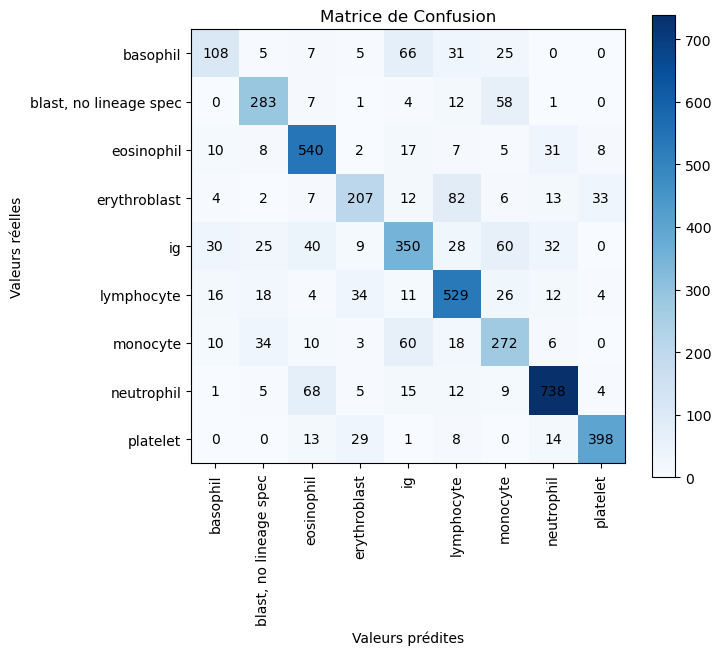

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Supposons que vous ayez déjà calculé votre matrice de confusion (confusion_mtx)
class_names = np.unique(y)
confusion_mtx=confusion_matrix(true_classes, predicted_classes)
# Afficher la matrice de confusion avec Matplotlib imshow
plt.figure(figsize=(7, 6))
plt.imshow(confusion_mtx, interpolation='nearest', cmap='Blues')
plt.title('Matrice de Confusion')
plt.colorbar()

# Définir les étiquettes des axes
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_labels, rotation=90)
plt.yticks(tick_marks, class_labels)

# Ajouter les valeurs dans les cellules
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(confusion_mtx[i, j]), ha='center', va='center')

plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.show()


In [28]:
model.save('reseau_dense.keras')